In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
sys.path.insert(1, os.path.join(sys.path[0], '../'))
from pipeline.utils import list_files # noqa
from pipeline.dataset_constructor import return_data_loaders, time_it # noqa

In [2]:
class ETPatchEmbed(nn.Module):
    """
    Takes a 1D convolution of a patch of ET data to embed in a lower dimensional space.
    """
    def __init__(self,
                 sample_height=300,
                 sample_width=3,
                 patch_size=15,
                 in_chans=64,
                 embed_dim=15):
        super().__init__()
        sample_size = tuple((sample_height, sample_width))
        patch_size = tuple((patch_size, sample_width))
        num_patches = (sample_size[1] // patch_size[1] * sample_size[0] // patch_size[0])
        self.sample_size = sample_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.norm = nn.BatchNorm1d(sample_height)
        self.conv_layer = nn.Conv1d(in_channels=sample_width,
                                    out_channels=embed_dim,
                                    kernel_size=15, stride=15)

    def forward(self, x):
        out = self.norm(x)
        out = self.conv_layer(out.permute(0, 2, 1))
        # print(x.shape)
        return out


class ETMLP(nn.Module):
    def __init__(self,
                 input_size=1200,
                 hidden_size=4096,
                 num_classes=335,
                 patch_size=100,
                 in_chans=4,
                 embed_dim=15):
        super().__init__()
        self.patch_embed = ETPatchEmbed(
            sample_height=300,
            sample_width=3,
            patch_size=15,
            in_chans=3,
            embed_dim=15)
        self.num_classes = num_classes
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(300, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2048, 1024)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(1024, num_classes)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        out = self.patch_embed(x)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        return out

In [3]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None,
                 out_features=None, act_layer=nn.GELU, drop=0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class ETAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor can be set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3,
                                  self.num_heads, C //
                                  self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # torchscript cannot use tensor as tuple

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = ETAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                                qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop = nn.Dropout(attn_drop)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.drop(self.mlp(self.norm2(x)))
        return x


class ETTransformer(nn.Module):
    def __init__(self, sample_height=300, sample_width=3, patch_size=20, in_chans=256,
                 num_classes=335, embed_dim=20, depth=6, num_heads=10, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop_rate=0.1, attn_drop_rate=0.1,
                 drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = ETPatchEmbed(sample_height=sample_height,
                                        sample_width=sample_width,
                                        patch_size=patch_size,
                                        in_chans=in_chans,
                                        embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, embed_dim + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads,
                  mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                  qk_scale=qk_scale, drop=drop_rate,
                  attn_drop=attn_drop_rate, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [17]:
TorchFormer = torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6,
                                   dim_feedforward=2048, dropout=0.1, custom_encoder=None,
                                   custom_decoder=None, layer_norm_eps=1e-05, batch_first=True,
                                   norm_first=False, device=None, dtype=None)

In [4]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [5]:
def train_pass(model, EPOCHS, loss_fn):
    """
    Train the model for a given number of epochs, and return the final loss.
    :param model: The model to train
    :param EPOCHS: The number of epochs to train for
    :param loss_fn: The loss function to use
    :return: The final loss
    """
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_dataloader):
        labels = data[:, 0, 0]  # Whole batch, first label, first timestamp
        labels = labels.type(torch.LongTensor) - 1
        inputs = data[:, 1:, 1:].float()  # Whole batch, exclude label, exclude timestamps
        inputs.requires_grad = True
        labels = labels.to(device)
        inputs = inputs.to(device)
        output = model(inputs)
        # break
        loss = loss_fn(output, labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
        if i % 250 == 249:
            last_loss = running_loss / 249
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
    return last_loss


def train_model(model, EPOCHS, loss_fn, batch_size=256, num_classes=335):
    loss_progress = []
    eval_labels = np.zeros((EPOCHS, len(test_dataloader.dataset)))
    eval_outputs = np.zeros((EPOCHS, len(test_dataloader.dataset), num_classes))
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))
        model.train(True)
        avg_loss = train_pass(model, EPOCHS, loss_fn)
        # break
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(test_dataloader):
            start_index = i * batch_size
            end_index = start_index + batch_size
            vlabels = vdata[:, 0, 0]
            vlabels = vlabels.type(torch.LongTensor) - 1
            vinputs = vdata[:, 1:, 1:].float()  # Whole batch, exclude label, exclude timestamps
            vlabels = vlabels.to(device)
            vinputs = vinputs.to(device)
            voutput = model(vinputs)
            if i == len(test_dataloader) - 1:
                num_samples_last_batch = len(vlabels)
                end_index = start_index + num_samples_last_batch
            eval_labels[epoch, start_index:end_index] = vlabels.detach().cpu().numpy()
            eval_outputs[epoch, start_index:end_index] = voutput.detach().cpu().numpy()
            vloss = loss_fn(voutput, vlabels)
            running_vloss += vloss
        avg_test_loss = running_vloss / (i + 1)
        loss_progress.append(avg_test_loss.cpu().detach())
        print('LOSS train {} valid {}'.format(avg_loss, avg_test_loss))
        
        early_stopping(avg_loss, avg_test_loss)
        if early_stopping.early_stop:
            print("We are at epoch:", i)
            break
    return eval_labels, eval_outputs, loss_progress

In [6]:
def topk_accuracy(eval_labels, eval_outputs, k=5, plot=False):
    """

    """
    topk_accuracy = []
    for i in range(len(eval_labels)):
        topk_classes = []
        for pred in eval_outputs[i]:
            classes = np.argsort(pred)[-k:]
            topk_classes.append(classes)
        correct = 0
        for j in range(len(eval_labels[i])):
            if eval_labels[i][j] in topk_classes[j]:
                correct += 1
        topk_accuracy.append(correct / len(eval_labels[i]))
    if plot:
        plt.plot(topk_accuracy)
        plt.title(f'Top {k} Accuracy over Epochs')
        plt.xlabel('Epoch Number')
        plt.ylabel('Accuracy')
        plt.savefig('T-50.png')
        plt.show()
    return topk_accuracy


def eval_plots(eval_labels=None, eval_outputs=None, loss_progress=None, cf=False, loss_plot=False):
    """
    Take the labels and outputs of the model after training and evaluate the model.
    outputs is a list of tensors, each of which is a batch of outputs. 
    It first converts this into a single prediction label with softmax and onehot encoding.
    Plots the progress of the loss function over the epochs.
    """
    if cf:
        labels = eval_labels[-1].astype(int)
        outputs = eval_outputs[-1]
        outputs = torch.softmax(torch.tensor(outputs), dim=1)
        outputs = torch.argmax(outputs, dim=1).numpy().astype(int)

        plt.figure(figsize=(20, 20))
        ax = plt.axes()
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        cf_matrix = confusion_matrix(labels, outputs)
        sn.heatmap(cf_matrix, annot=True, xticklabels=np.unique(outputs), yticklabels= np.unique(labels),
                fmt='g', cmap='Blues', linewidths=0.5, ax=ax)
        plt.savefig('T-50-CF.png')
        plt.show()
    if loss_plot:
        loss = np.array(loss_progress)
        plt.plot(loss)
        plt.xlabel('Epoch Number')
        plt.ylabel('Loss')
        plt.savefig('T-50-Loss.png')
        plt.show()

In [19]:
model = ETTransformer()
# model = TorchFormer
early_stopping = EarlyStopping(tolerance=2, min_delta=0.1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.01, capturable=True, weight_decay=0.001)
folder = os.path.abspath(os.path.join('..', 'DS10'))
files = list_files(folder)
train_dataloader, test_dataloader = return_data_loaders(files, 98, 28, batch_size=350)


EPOCHS = 50
eval_labels, eval_outputs, loss_progress = train_model(model, EPOCHS, loss_fn, batch_size=350)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 6.80 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

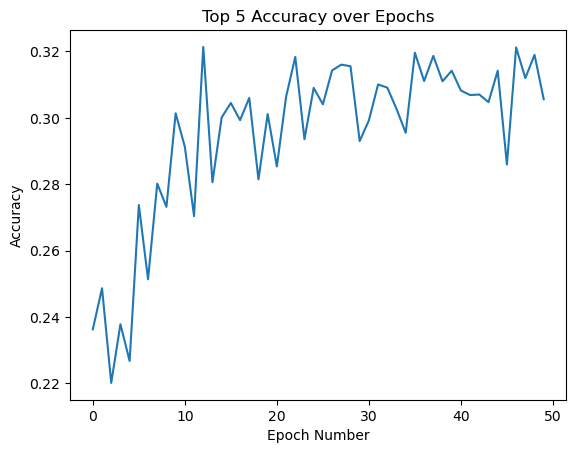

0.32134044416142643


In [8]:
top5_acc = topk_accuracy(eval_labels, eval_outputs, k=5, plot=True)
print(max(top5_acc))

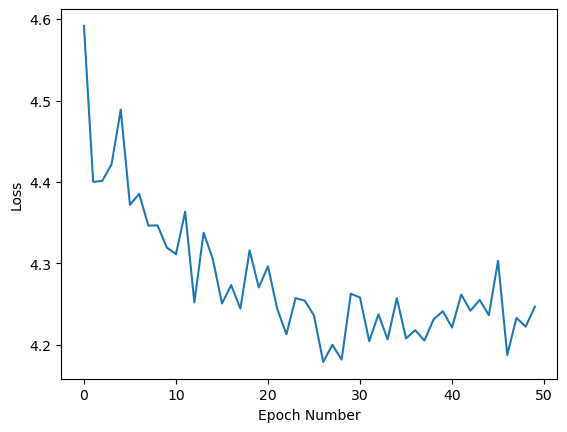

In [9]:
eval_plots(loss_progress=loss_progress, loss_plot=True)